In [33]:
import torch
import torchvision
from torch import nn
from torch.nn import init
import torchvision.transforms as transforms
import numpy as np
import sys
from demo_utils import snn_utils as snnu
from demo_utils import demo_utils as du
from torch.utils.data import random_split

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

In [34]:
batch_size = 256

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor()      # Automative transforming pixels' value from [0,255] to [0,1]
            # transforms.Normalize((0.5,), (0.5,))
            ])

fmnist_train = torchvision.datasets.FashionMNIST(root='D:/SoftProject/Python/PyTorch_demo/Datasets/FashionMNIST',train=True, download=True, transform=transform)
fmnist_test = torchvision.datasets.FashionMNIST(root='D:/SoftProject/Python/PyTorch_demo/Datasets/FashionMNIST', train=False, download=True, transform=transform)

inference_size = 2000  
test_size = len(fmnist_test) - inference_size
test_dataset, infer_dataset = random_split(fmnist_test, [test_size, inference_size])

In [35]:
train_loader = torch.utils.data.DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
infer_loader = torch.utils.data.DataLoader(infer_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
num_inputs = 784
num_hiddens= 1500
num_outputs = 10

num_epochs=10
lr=1e-4

# Temporal Dynamics
num_steps = 50
beta = 0.95

match_name="demo_rs"
remark=f"opt=adam,lr={lr},beta={beta},num_steps={num_steps},reset(sub,0)"

findex=du.get_next_demo_index("rec/",match_name)

filename=f"{match_name}{findex}"

suptitle=f"{filename}--{remark}"

sub_title=f"{filename}-{remark}"


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

from collections import OrderedDict


net = nn.Sequential(
    # FlattenLayer(),       # unnamed layer, use layer1.parameters() or layer1.weight to access
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        # ('rate', snnu.RateEncodingLayer(num_steps=num_steps)),
        ('linear1', nn.Linear(num_inputs, num_hiddens)),
        ('leaky1', snn.Leaky(beta=beta, init_hidden=True)), # activate `init_hidden` to use nn.Sequential. It will cause Leaky layer only returns spikes
        # ('active', ReLuFunction()),
        # ('active', nn.ReLU()),
        ('linear2',nn.Linear(num_hiddens, num_outputs)),
        ('leaky2', snn.Leaky(beta=beta, init_hidden=True, output=True,reset_mechanism="zero")) # Last layer set `output=true`, to output membrane potential
    ])
).to(device)

for _, layer in net.named_modules():
    if isinstance(layer, nn.Linear):
        
        init.normal_(layer.weight, mean=0, std=0.01)
        init.constant_(layer.bias, val=0)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))



In [37]:
results=snnu.train_snn(net,train_loader,test_loader,loss,num_epochs,optimizer,
                       num_steps,infer_loader=infer_loader, in2spk=True, device=device)



![alt text](pic/rate.png)

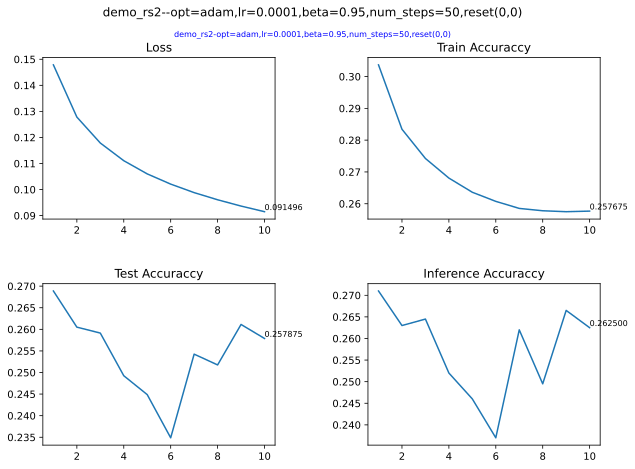

In [38]:

du.plot_acc(num_epochs,results[0],results[1],results[2],results[3],
             suptitle=suptitle, sub_title=sub_title)

In [39]:
du.store_record(results, filename, one_time=True)

Data of demo_rs2 is saved!


In [40]:
# res_fr_file=du.load_sin_res(f"rec/{filename}.csv")

# du.plot_acc(len(res_fr_file[0]),res_fr_file[0],res_fr_file[1],res_fr_file[2],res_fr_file[3],
#              suptitle=suptitle, sub_title=suptitle, store_pic=False)